# altimetry/gdp collocalisation

Database extension:

- [ ] add GPS-drifter collocations
- [ ] add another satellite
- [ ] extend to one year


To do:

- [ ] generate local rotated carthesian coordinates
- [ ] setup boxed lags (allow time lag on top of space one)
- [ ] setup AVISO interpolation


In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram

import m2lib22.sat as sat

import warnings
warnings.filterwarnings("ignore")

In [16]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33420/status,
Dashboard: http://127.0.0.1:33420/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58893,Workers: 8
Dashboard: http://127.0.0.1:33420/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:49704,Total threads: 7
Dashboard: http://127.0.0.1:45223/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:49036,


---
## load data

Need to chunk a bit along `obs` dimension

- `site_obs`: drifter time
- `sassa_time`: satellite time


In [17]:
# A deplacer dans la bibliothèque

import os
from glob import glob

colloc_path = {2016: '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/mdb/2016/',
               2018: '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb/2018/',
              }

def load_collocalisations(source, satellite=None, drifter=None):
    """ Load collocalisations altimetry / GDP data
    
    Parameters
    ----------
    source : str, int
        Data source, e.g. 2016, 2018
    satellite : str
        type of satellite we want to select among "SARAL" or "Sentinel"  (if we want to) 
    drifter : str
        type of drifter we want to select among "gps" or "argos" (if we want to) 
    
    Return
    ------
    list of .nc files
    
    """
    files = sorted(glob(os.path.join(colloc_path[source], "*.nc")))
    
    if satellite is not None:
        files = [f for f in files if satellite in f]
    if drifter is not None:
        files = [f for f in files if drifter in f]
        
    return files

In [18]:
def getprefix(ds):
    """ Find the data prefixes
    
    Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset
        
    Return
    ------
    drifters prefix, satellite prefix : str, str
    
    """
    argos = any(["argos" in variable for variable in list(ds)])
    #gps = any(["gps" in variable for variable in list(ds)])

    if argos:
        dsuff = "argos_drifters"
    else:
        dsuff = "gps_drifters"
    print(f"drifters data are of the following type: {dsuff}")
    
    asuff = "sassa"

    return dsuff, asuff

In [19]:
#load_collocalisations(2018)
nc_files = load_collocalisations(2018,drifter='gps')
nc = nc_files[0]
ds = xr.open_dataset(nc).persist()

#get prefixes
dsuff,asuff=getprefix(ds)

# add several variables in coords
ds = (ds
      .set_coords([dsuff+"_"+d for d in ["time", "lon", "lat"]])
      .set_coords([asuff+"_"+d for d in ["time_", "lon", "lat"]])
     )


print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
#nc_files

drifters data are of the following type: gps_drifters
Dataset size = 1.3 GB


In [ ]:
# ds = ds.rename({v: v.replace(dsuff, "drifters") for v in list(ds) if dsuff in v})

### add local coordinates oriented along the altimetric track

In [20]:
def get_proj(lonc, latc):#converts from lon, lat to native map projection x,y
    """ Create pyproj Proj object, project is an azimutal Eqsuidistant projection centered on the central point of the selected satellite track = matching point
    https://proj.org/operations/projections/aeqd.html
            
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    Return
    ------
    pyproj.Proj object
    """
    return pyproj.Proj(proj="aeqd", lat_0=latc, lon_0=lonc, datum="WGS84", units="m")#aeqd Azimutal EQuiDistant projection centered on lonc,latc

def compute_box_orientation(lonc, latc, lon1, lat1):
    """Compute the orientation of the box i.e. the angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe.
        
    Parameters
    ----------
    lonc,latc : float
        central longitude and latitude of the satellite track, matching point on which the box will be centered
    lon1,lat1 : float
        longitude and latitude of the end of the satellite track
    Return
    ------
    box orientation
    """
    proj = get_proj(lonc, latc)
    # get local coordinate
    xc, yc = proj.transform(lonc, latc) #xc=yc=0 origin of the box grid
    x1, y1 = proj.transform(lon1, lat1)
    # get orientation of defined by central point and point 1
    #print(lonc,latc,xc,yc,x1,y1)
    phi = np.arctan2( y1-yc, x1-xc )*180/np.pi # angle (-180 and 180°) between the oriented track (time=0 -> end) and the longitude axe
    return phi
    
#compute_box_vec = np.vectorize(compute_box_core)

def compute_box(ds, asuff):
    """ Compute box properties around each collocation: 
    central position and orientation
    
    Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset
    asuff : str
        satellite prefixe

    Return
    ------
    central longitude, central latitude, orientation : xr.Datarray, xr.Datarray, xr.Datarray
    """
    i = (ds[asuff+"_time"].size-1)//2
    lonc = ds[asuff+"_lon"].isel(sassa_time=i)
    latc = ds[asuff+"_lat"].isel(sassa_time=i)
    lon1 = ds[asuff+"_lon"].isel(sassa_time=-1)
    lat1 = ds[asuff+"_lat"].isel(sassa_time=-1)

    # will need to vectorize with dask eventually
    phi = xr.apply_ufunc(compute_box_orientation,
                   lonc, latc,
                   lon1, lat1,
                   #input_core_dims = [[]]*4,
                   vectorize=True,
                        ).rename("phi")
    #phi = compute_box_vec(lonc, latc, lon1, lat1)    

    return lonc, latc, phi

ds["box_lonc"], ds["box_latc"], ds["box_phi"] = compute_box(ds, asuff)

In [21]:
def compute_box_grid_lonlat_core(lonc, latc, phi, x=None, y=None):
    """ Compute coordinates longitude, latitude of the local box grid (x-along satellite track, y-normal to satellite track -> lon,lat)
    https://github.com/rasterio/affine
    
    Parameters
    ----------
    lonc, latc, phi: float  central position and orientation of the box
    x, y: np.array local grid of the box (with origin at (lonc, latc) and x-axis aligned 
    with the satellite track (lonc, latc) - (lon1, lat1) direction)
    
    Return
    ------
    longitude, latitude : np.array, np.array
    
    """
    xv, yv = np.meshgrid(x, y)
    proj = get_proj(lonc, latc)
    #assert False, help(proj.transform)
    xc, yc = proj.transform(lonc, latc)
    # apply inverse affine transformation
    a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
    a_back = ~a_fwrd
    #compute coordinates of x,y in the lon, lat orientated grid
    xv_inv, yv_inv = a_back * (xv, yv) 
    lon, lat = proj.transform(xv_inv, yv_inv, 
                              direction=pyproj.enums.TransformDirection.INVERSE,
                             )
    return lon, lat

def compute_box_grid_lonlat(ds, x, y):
    """ Compute local coordinates in longitude, latitude of the local box grid (x-along satellite track, y-normal to satellite track -> lon,lat) for all colocalisations
    
     Parameters
    ----------
    ds : xr.DataArray
        colocalisations dataset 
    x, y: np.array      
        local grid of the box (with origin at (lonc, latc) and x-axis aligned )
    
    Return
    ------
    longitude, latitude : xr.Datarray, xr.Datarray
      
    """
    lon, lat = xr.apply_ufunc(compute_box_grid_lonlat_core,
                   ds.box_lonc, ds.box_latc, ds.box_phi,
                   kwargs=dict(x=x, y=y),
                   output_core_dims = [["box_y", "box_x"]]*2,
                   vectorize=True,
                  )
    lon = lon.assign_coords(box_x=x, box_y=y)
    lat = lat.assign_coords(box_x=x, box_y=y)
    return lon, lat

In [22]:
# define the local grid
x = np.arange(-200e3,200e3,5e3)
y = np.arange(-100e3,100e3,5e3)

ds["box_lon"], ds["box_lat"] = compute_box_grid_lonlat(ds, x, y)


In [23]:
def lonlat2xy(lonc, latc, phi, lon, lat, lon1=None, lat1=None):
    """ return coordinates with origin at (lonc, latc) and x-axis aligned 
    with (lonc, latc) - (lon1, lat1) direction (lon,lat -> x-along satellite track, y-normal to satellite track)
    
    Parameters
    ----------
    lonc, latc, phi: float  
        central position and orientation of the box
    lon, lat : np.array, np.array     
        local grid of the box
    lon1,lat1 : float      
        end of the satellite track
    
    Return
    ------
    local x, local y : np.array, np.array
      
    """
    proj = get_proj(lonc, latc)
    # get local coordinate
    xc, yc = proj.transform(lonc, latc)    
    xl, yl = proj.transform(lon, lat)
    if phi is None:
        # compute phi from x1 and y1
        x1, y1 = proj.transform(lon1, lat1)
        # get orientation of defined by central point and point 1
        phi = np.arctan2( y1-yc, x1-xc )*180/np.pi
    # build affine operators
    a_fwrd = Affine.translation(-xc, -yc) * Affine.rotation(-phi, pivot=(xc, yc))
    #a_back = ~a_fwrd
    
    x, y = a_fwrd * (xl, yl)
    
    return x, y

def compute_local_xy(ds, suff, tdim):
    """return coordinates with origin at (lonc, latc) and x-axis aligned
    with (lonc, latc) - (lon1, lat1) direction (lon,lat -> x-along satellite track, y-normal to satellite track) for all colocalisations
    
    Parameters
    ----------
    ds: xr.DataArray
        colocalisations dataset
    suff : str        
        data prefix
    tdim : str
        time dimension of data with prefix suff
    
    Return
    ------
    local x, local y : xr.Datarray, xr.Datarray
      
    """

    lon = ds[suff+"_lon"]
    lat = ds[suff+"_lat"]

    # will need to vectorize with dask eventually
    x, y = xr.apply_ufunc(lonlat2xy,
                   ds.box_lonc, ds.box_latc, ds.box_phi,
                   lon, lat,
                   input_core_dims = [[]]*3+[[tdim]]*2,
                   output_core_dims = [[tdim]]*2,
                   vectorize=True,
                  )
    return x, y

In [24]:
def vevn2vxvy(lonc, latc, phi,ve, vn):
    """ Compute velocities projected on the local box grid (ve, vn -> vx-along satellite track, vy-normal to satellite track)
    https://github.com/rasterio/affine
    
    Parameters
    ----------
    lonc, latc, phi: float  central position and orientation of the box
    ve,vn: np.array velocities on lon, lat grid
        
    Return
    ------
    local vx, local vy : np.array, np.array
      
    """
    proj = get_proj(lonc, latc)
    #assert False, help(proj.transform)
    xc, yc = proj.transform(lonc, latc)
    # apply inverse affine transformation
    a_fwrd = Affine.rotation(-phi, pivot=(xc, yc))
    return a_fwrd*(ve,vn)

def compute_local_drifters_velocities(ds, dsuff, tdim):
    """ Compute local coordinates lon, lat of the local grid of the box (x-along satellite track, y-normal to satellite track -> lon,lat) for all colocalisations
    
     Parameters
    ----------
    ds : xr.DataArray  
        colocalisations dataset
    suff : str        
        data prefix
    tdim : str
        time dimension of data with prefix suff
    
    Return
    ------
    local vx, local vy : xr.Datarray, xr.Datarray
      
    """
    ve=ds[dsuff+"_ve"]
    vn=ds[dsuff+"_vn"]
    
    # will need to vectorize with dask eventually
    vx, vy = xr.apply_ufunc(vevn2vxvy,
                          ds.box_lonc, ds.box_latc, ds.box_phi,
                          ve, vn,
                          input_core_dims = [[]]*3+[[tdim]]*2,
                          output_core_dims = [[tdim]]*2,
                          vectorize=True,
                         )
    return vx, vy

In [25]:
ds[dsuff+"_x"], ds[dsuff+"_y"] = compute_local_xy(ds, dsuff, "site_obs")
ds[dsuff+"_vx"], ds[dsuff+"_vy"] = compute_local_drifters_velocities(ds, dsuff, "site_obs")
ds = ds.set_coords([dsuff+"_x", dsuff+"_y"])

ds[asuff+"_x"], ds[asuff+"_y"] = compute_local_xy(ds, asuff, asuff+"_time")
ds = ds.set_coords([asuff+"_x", asuff+"_y"])

# rotate driter velocities: create new variables vx, vy
# def rotate(u,v,phi):
#   # d!! deg/rad
#   return u*np.cos(phi) +- v... , ...

In [26]:
#ds1=ds.isel(obs=0)
#phi=ds1.box_phi
#print(ds[dsuff+"_vx"],ds[dsuff+"_vx"])
#print(np.cos(phi)*ds[dsuff+"_ve"]+np.sin(phi)*ds[dsuff+"_vn"])
#print(-np.sin(phi)*ds[dsuff+"_ve"]+np.cos(phi)*ds[dsuff+"_vn"])

In [27]:
# persist data in memory
#ds = ds.persist()

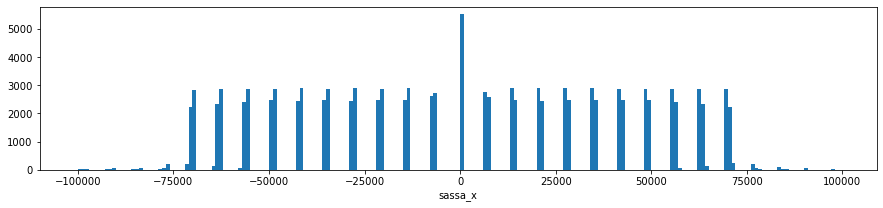

In [28]:
fig = plt.figure(figsize=(15,3))
bins=np.arange(-100e3,100e3,1e3)
ds[asuff+"_x"].plot.hist(bins=bins);
#ds[asuff+"_y"].plot.hist(bins=bins);

Regular sample along the satellite track (x direction )

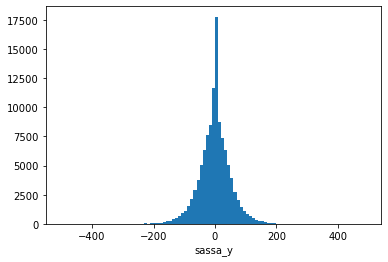

In [29]:
bins=np.arange(-5e2,5e2,1e1)
ds[asuff+"_y"].plot.hist(bins=bins);

In [ ]:
#bins=np.arange(-5e2,5e2,1e1)
#ds[asuff+"_y"].isel(**{asuff+"_time": 10}).plot.hist(bins=bins)

In [ ]:
#bins=np.arange(-5e2,5e2,1e1)
#ds[asuff+"_y"].isel(**{asuff+"_time": -1}).plot.hist(bins=bins)

In [ ]:
#bins=np.arange(-5e2,5e2,1e1)
#ds[asuff+"_y"].isel(**{asuff+"_time": 0}).plot.hist(bins=bins)

Non zero values mean that the track do not exactly follow the direction estimated from lonc,latc-lon1,lat1 -> uncertainty ? 

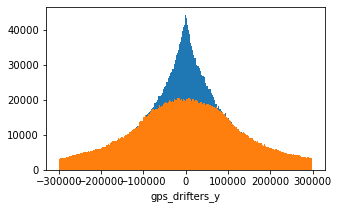

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
bins=np.arange(-300e3,300e3,1e3)
ds[dsuff+"_x"].plot.hist(bins=bins, label="x");
ds[dsuff+"_y"].plot.hist(bins=bins, label="y");
#max.legend()

Where does this peak on x come from ? Les bouées se déplacent plus à l'orthogonale de la trace du satelite ? (trace + méridienne et vitesse plutôt zonale (importance du ACC, ou GS ? où on a beaucoup de colocalisation)

In [ ]:
# pdf joint x/y
# xhistogram

### add along-track sla gradient

In [31]:
t = ds[asuff+"_time"]
tc = (t + t.shift({asuff+"_time": -1}))*0.5 # C
tc = tc[:-1].rename({asuff+"_time": asuff+"_time_mid"})

ds = ds.assign_coords(**{asuff+"_time": t, asuff+"_time_mid": tc})
grid = Grid(ds, coords={"t": {"center": "sassa_time_mid", "outer": "sassa_time"}})

ds[asuff+"_x_mid"] = grid.interp(ds[asuff+"_x"], axis="t")
ds[asuff+"_y_mid"] = grid.interp(ds[asuff+"_y"], axis="t")
ds = ds.set_coords([asuff+"_x_mid", asuff+"_y_mid"])

In [32]:
#dt = grid.diff(ds[asuff+"_time_"], axis="t")/pd.Timedelta("1S")
dx = grid.diff(ds[asuff+"_x"], axis="t")
dy = grid.diff(ds[asuff+"_y"], axis="t")
dxy = np.sqrt(dx**2+dy**2)

g = 9.81
dsla = grid.diff(ds[asuff+"_sla"], axis="t")
ds["g_grad_sla"] = g*dsla/dxy

dsla = grid.diff(ds[asuff+"_sla_denoised"], axis="t")
ds["g_grad_sla_denoised"] = g*dsla/dxy

# add Coriolis frequency
ds["f"] = 2 *2*np.pi/86164.1 * np.sin(ds.lat*np.pi/180)

In [33]:
ds

<xarray.Dataset>
Dimensions:                         (obs: 5520, site_obs: 1489, sassa_time: 21,
                                     box_x: 80, box_y: 40, sassa_time_mid: 20)
Coordinates: (12/19)
    time                            (obs) datetime64[ns] ...
    lon                             (obs) float64 ...
    lat                             (obs) float64 -30.49 -30.88 ... 15.63 15.75
    gps_drifters_time               (obs, site_obs) datetime64[ns] ...
    gps_drifters_lon                (obs, site_obs) float64 ...
    gps_drifters_lat                (obs, site_obs) float64 ...
    ...                              ...
    sassa_x                         (obs, sassa_time) float64 -7.028e+04 ... ...
    sassa_y                         (obs, sassa_time) float64 -1.792 ... 4.18...
  * sassa_time                      (sassa_time) int64 0 1 2 3 4 ... 17 18 19 20
  * sassa_time_mid                  (sassa_time_mid) float64 0.5 1.5 ... 19.5
    sassa_x_mid                     (obs, sassa_time_mid) float64 -6.673e+04 ...
    sassa_y_mid                     (obs, sassa_time_mid) float64 8.217 ... -...
Dimensions without coordinates: obs, site_obs
Data variables: (12/53)
    __site_id                       (obs) object ...
    __site_name                     (obs) object ...
    gps_drifters_rowsize            (obs, site_obs) float64 ...
    gps_drifters_WMO                (obs, site_obs) float64 ...
    gps_drifters_expno              (obs, site_obs) float64 ...
    gps_drifters_deploy_date        (obs, site_obs) datetime64[ns] ...
    ...                              ...
    box_lat                         (obs, box_y, box_x) float64 -28.6 ... 17.23
    gps_drifters_vx                 (obs, site_obs) float32 0.02993 ... -0.2139
    gps_drifters_vy                 (obs, site_obs) float32 0.03562 ... -0.03246
    g_grad_sla                      (obs, sassa_time_mid) float64 1.655e-05 ....
    g_grad_sla_denoised             (obs, sassa_time_mid) float64 1.313e-05 ....
    f                               (obs) float64 -7.4e-05 ... 3.958e-05
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2018-02-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

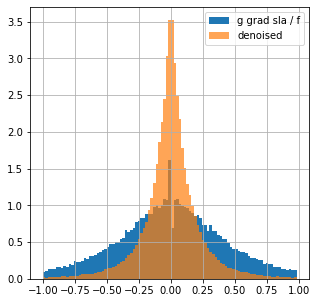

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
bins=np.arange(-1,1,.02)
(ds["g_grad_sla"]/ds.f).plot.hist(bins=bins, density=True, label="g grad sla / f")
(ds["g_grad_sla_denoised"]/ds.f).plot.hist(bins=bins, density=True, label="denoised", alpha=.7)

ax.legend()
ax.grid()

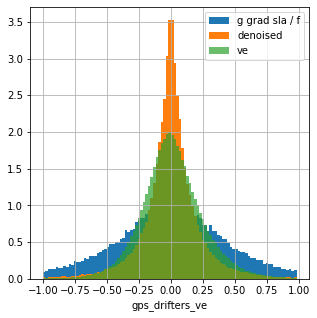

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
bins=np.arange(-1.,1.,.02)
(ds["g_grad_sla"]/ds.f).plot.hist(bins=bins, density=True, label="g grad sla / f")
(ds["g_grad_sla_denoised"]/ds.f).plot.hist(bins=bins, density=True, label="denoised")
ds[dsuff+"_ve"].plot.hist(bins=bins, density=True, label="ve", alpha=.7)
#ds[dsuff+"_vn"].plot.hist(bins=bins, density=True, label="vn", alpha=.7)

ax.legend()
ax.grid()

Why is the pdf of velocity wider? plausible explanations

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
bins=np.arange(-1,1,.02)
ds[dsuff+"_ve"].plot.hist(bins=bins, density=True, label="ve", alpha=.7)
ds[dsuff+"_vn"].plot.hist(bins=bins, density=True, label="vn", alpha=.7)

ax.legend()
ax.grid()

Diagnostic illustrating the geostrophic accuracy

---

## global overview

In [ ]:
t_max = pd.to_datetime(ds.time.max().values)
t_min = pd.to_datetime(ds.time.min().values)
print(f" {t_min} to {t_min}, {t_max-t_min}")

### overview map

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.EckertIII(central_longitude=-180))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

#for o in ds.obs:
#    _ds = ds.sel(obs=o)
#    ax.plot(_ds.sassa_lon, _ds.sassa_lat, color="0.9", transform=ccrs.PlateCarree())

ax.plot(ds.lon, ds.lat, ".", transform=ccrs.PlateCarree())

gl = ax.gridlines()

ccrs.EckertIII ?

### count occurences in bins

In [ ]:
dl = 2
lon, lat = np.arange(-180, 180, dl), np.arange(-90,90,dl)

count = histogram(ds.lon, ds.lat, bins=[lon, lat], bin_dim_suffix='')
print(count)
count = count.where(count>0)
count.plot.hist(bins=np.arange(0,20))

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.EckertIII(central_longitude=-180))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

count.plot(x="lon", y="lat", ax=ax,
           vmax = 10,
           transform=ccrs.PlateCarree())

#ax.plot(ds.lon, ds.lat, ".", transform=ccrs.PlateCarree())

gl = ax.gridlines()

Why are there as many colocalisations in the Groenland Sea ?
Does this map match the one of drifters repartition ? 

In [ ]:
count.sum("lon").plot()

## separation statistics

In [ ]:
ds[asuff+"___distance"].plot.hist(bins=30)

---

## focus on on a single matchup

In [ ]:
i = 0
_ds = ds.isel(obs=i)

lon, lat, t = float(_ds.lon), float(_ds.lat), _ds.time.values
td = pd.to_datetime(t)
dt = float(_ds[asuff+"___time_difference"])
dl = float(_ds[asuff+"___distance"])

a_deltat = float((_ds[asuff+"_time_"].max() - _ds[asuff+"_time_"].min())
                 /pd.Timedelta("1S")
                )

_dsm = _ds.isel(site_obs=_ds.__site_matchup_indice)

print(f" time difference = {dt/60:.1f} minutes")
print(f" separation = {dl/1e3:.1f} km")
print(f" satellite pass length = {a_deltat:.1f} seconds")


In [ ]:
# load and interpolate aviso
aviso = sat.load_aviso(_ds.time.values, (-5,5))
sla = aviso.sla.interp(lon=_ds.box_lon.drop("time"), 
                       lat=_ds.box_lat.drop("time"),
                      )
slam = sla.interp(time=_dsm.time)

In [ ]:
# load and interpolate era5
era5 = sat.load_era5(_ds.time.values, (-5,5))
u10 = era5.u10.interp(lon=_ds.box_lon.drop("time"), 
                      lat=_ds.box_lat.drop("time"),
                      )
v10 = era5.v10.interp(lon=_ds.box_lon.drop("time"), 
                      lat=_ds.box_lat.drop("time"),
                      )
u10m = u10.interp(time=_dsm.time)
v10m = v10.interp(time=_dsm.time)

### overview map


In [ ]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))

land_feature = cfeature.LAND
ax.add_feature(land_feature, zorder=2)

# aviso
ax.contourf(_ds.box_lon, _ds.box_lat, slam, levels=30, cmap=cm.diff, transform=crs)
#ax.plot(_ds.box_lon[::10,::10], _ds.box_lat[::10,::10], "+", color="k", transform=crs)


# drifter
ax.plot(_ds[dsuff+"_lon"], _ds[dsuff+"_lat"], color="k", lw=2, transform=crs)
ax.plot(_ds[dsuff+"_lon"][0], _ds[dsuff+"_lat"][0], "o", ms=10, color="k", transform=crs)
ax.plot(_ds[dsuff+"_lon"][-1], _ds[dsuff+"_lat"][-1], "x", ms=10, color="k", transform=crs)

ax.plot(_dsm[dsuff+"_lon"], _dsm[dsuff+"_lat"], 
        "*", ms=20, color="orange", lw=2, transform=crs)

# altimetry
#ax.plot(_ds[asuff+"_lon"], _ds[asuff+"_lat"], color="orange", lw=2, transform=crs)
_sla = _ds[asuff+"_sla_denoised"]
_sla = _sla - _sla.min()
ax.scatter(_ds[asuff+"_lon"], _ds[asuff+"_lat"], s=_sla*1000, color="orange", transform=crs)
ax.plot(_ds[asuff+"_lon"][0], _ds[asuff+"_lat"][0], "o", ms=10, color="orange", transform=crs)
ax.plot(_ds[asuff+"_lon"][-1], _ds[asuff+"_lat"][-1], "x", ms=10, color="orange", transform=crs)

gl = ax.gridlines(draw_labels=True, dms=False, 
             x_inline=False, y_inline=False, 
            )
gl.right_labels=False
gl.top_labels=False

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , "+td.strftime("%Y/%m/%d %H:%M"))

In [ ]:
fig, ax = plt.subplots(1,1)
_ds.sassa_sla.plot(label="sla")
_ds.sassa_sla_denoised.plot(label="sla denoised")
(_ds.sassa_mdt-_ds.sassa_mdt.mean()).plot(label="demeaned geoid")
ax.legend()

---
## box stats



In [ ]:
dx = 1e3
x, y = np.arange(-100e3, 100e3, dx), np.arange(-100e3,100e3, dx)

_ds = ds.isel(site_obs=_ds.__site_matchup_indice)

count = histogram(_ds[dsuff+"_x"], _ds[dsuff+"_y"], 
                  bins=[x, y], bin_dim_suffix='')
count = count.where(count>0)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
np.log10(count).plot()

In [ ]:
fig, ax = plt.subplots(1,1)
count.sum(dsuff+"_y").plot()
ax.grid()

In [ ]:
fig, ax = plt.subplots(1,1)
count.sum(dsuff+"_x").plot()
ax.grid()

---

## aviso & era5 overview

In [ ]:
sla.plot(col="time", col_wrap=3)

In [ ]:
np.sqrt(u10**2+v10**2).isel(time=slice(0,None,6)).plot(col="time", col_wrap=4)